# Required Libraries

In [1]:
# import required libraries

import os
import random
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageEnhance
import cv2

from tensorflow.keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras.layers import (
    Input, Activation, Add, UpSampling2D, BatchNormalization, Conv2D, Dense,
    concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten, Lambda,
    Dropout, Reshape, Conv2DTranspose, MaxPooling2D, LeakyReLU, Layer
)
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.models import load_model
from keras.models import load_model
import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Custom Keras Layer

In [3]:
# custom keras layer
# applies reflection (mirror) padding - helps reduce edge effects
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), data_format='channels_last', **kwargs):
        super().__init__(**kwargs)

        # standardize the padding input - ((top, bottom) , (left, right))
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif isinstance(padding, tuple):
            self.padding = padding
        else:
            raise ValueError(f"Invalid padding: {padding}")
        self.data_format = data_format

        # expected number of inputs = 4
        self.input_spec = InputSpec(ndim=4)

    # apply reflection padding to the input tensor
    def call(self, inputs):
        if self.data_format == 'channels_first':
          # B C H W
            pattern = [[0, 0], [0, 0], list(self.padding[0]), list(self.padding[1])]
        else:
          # B H W C
            pattern = [[0, 0], list(self.padding[0]), list(self.padding[1]), [0, 0]]
        return tf.pad(inputs, pattern, mode='REFLECT')

    # compute the output shape after padding
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            rows = input_shape[2] + sum(self.padding[0]) if input_shape[2] else None
            cols = input_shape[3] + sum(self.padding[1]) if input_shape[3] else None
            return (input_shape[0], input_shape[1], rows, cols)
        else:
            rows = input_shape[1] + sum(self.padding[0]) if input_shape[1] else None
            cols = input_shape[2] + sum(self.padding[1]) if input_shape[2] else None
            return (input_shape[0], rows, cols, input_shape[3])


# Model Architecture

In [10]:
# image and model architecture
image_shape = (256, 256, 3)
# number of generator filters in the first conv. layer
ngf = 64
# number of disc. filters in the first conv. layer
ndf = 64
# number of residual blocks in the gen.
n_blocks_gen = 9

# Residual Block

In [11]:
# residual block for the generator
def res_block(input, filters):
    x = ReflectionPadding2D(1)(input)
    x = Conv2D(filters, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ReflectionPadding2D(1)(x)
    x = Conv2D(filters, (3, 3))(x)
    x = BatchNormalization()(x)
    return Add()([input, x])

# Generator

In [12]:
# generator network

def generator_model():
    inputs = Input(shape=image_shape)

    # 7x7 conv. with reflection padding
    x = ReflectionPadding2D(3)(inputs)
    x = Conv2D(ngf, (7, 7), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # downsampling - 2 layers with stride = 2
    for i in range(2):
        x = Conv2D(ngf * 2**(i+1), (3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # residual blocks
    for _ in range(n_blocks_gen):
        x = res_block(x, ngf * 4)

    # upsamplingL 2 layers with nearest neighbor + conv.
    for i in range(2):
        x = UpSampling2D()(x)
        x = Conv2D(int(ngf * 4 / 2**(i+1)), (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # 7x7 conv. with tanh activation
    x = ReflectionPadding2D(3)(x)
    x = Conv2D(3, (7, 7), padding='valid')(x)
    x = Activation('tanh')(x)

    # residual connection
    x = Add()([x, inputs])

    # scale output to [-1,1]
    outputs = Lambda(lambda z: z / 2)(x)
    return Model(inputs, outputs)

# Discriminator

In [13]:
# discriminator network
# PatchGAN-Sytle discriminator

def discriminator_model():
    inputs = Input(shape=image_shape)
    x = Conv2D(ndf, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    # progressive convolutional layers with increasing filters
    for i in range(3):
        x = Conv2D(ndf * min(2**(i+1), 8), (4, 4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    # final conv. and dense layers
    x = Conv2D(1, (4, 4), strides=1, padding='same')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs, x)

In [14]:
# combined model

def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    input_img = Input(shape=image_shape)
    # generated image
    gen_out = generator(input_img)
    # evaluate the image
    dis_out = discriminator(gen_out)
    return Model(inputs=input_img, outputs=[gen_out, dis_out])

# VGG16

In [15]:
# load pretrained VGG16 for feature extraction
vgg = VGG16(
    include_top=False,            # exclude fully connected layers
    weights='imagenet',           # load pretrained ImageNet weights
    input_shape=image_shape       # match training image dimensions
)
# freeze all VGG layers
vgg.trainable = False

# extract features from an intermediate layer = block3_conv
vgg_loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
vgg_loss_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Loss Functions

In [16]:
# perceptual loss function
# computes the MSE between feature representations of the ground truth and img. extracted from vgg16
def perceptual_loss(y_true, y_pred):
    vgg_true = vgg_loss_model(y_true)
    vgg_pred = vgg_loss_model(y_pred)
    return K.mean(K.square(vgg_true - vgg_pred))

In [17]:
# wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# Load Images

In [18]:
# function to get all images
def list_image_files(directory):
    return sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])


In [19]:
# utility function to load and process images
def load_and_preprocess_image(path):
    img = Image.open(path).convert('RGB').resize((256, 256))
    return (np.array(img).astype('float32') - 127.5) / 127.5

In [20]:
# load paired blur/sharp images from the folders
# base path = root path containing subdirs. fo sequences
# sequences = list of folder names to load
# n_images = # of image pairs to load randomly

def load_images_from_sequences(base_path, sequences, n_images):
    all_blur_paths, all_sharp_paths = [], []

    # iterate over each folder
    for seq in sequences:
        blur_dir = os.path.join(base_path, seq, "blur")
        sharp_dir = os.path.join(base_path, seq, "sharp")
        blur_images = sorted(list_image_files(blur_dir))
        sharp_images = sorted(list_image_files(sharp_dir))

        # pair correspoding blur and sharp images
        for b, s in zip(blur_images, sharp_images):
            all_blur_paths.append(b)
            all_sharp_paths.append(s)

    paired = list(zip(all_blur_paths, all_sharp_paths))
    random.shuffle(paired)
    paired = paired[:n_images]

    blur_imgs = [load_and_preprocess_image(b) for b, _ in paired]
    sharp_imgs = [load_and_preprocess_image(s) for _, s in paired]

    return {
        # array of blurred images
        'A': np.array(blur_imgs),
        # array of corresponding shape images
        'B': np.array(sharp_imgs),
        # path to blurred images
        'A_paths': [b for b, _ in paired],
        # path to sharp images
        'B_paths': [s for _, s in paired]
    }


In [21]:
def save_all_weights(d, g, epoch_number, loss_value):
    g.save(f"/content/drive/My Drive/DSAN6500_Project/generator_{epoch_number}_{loss_value}.keras")
    d.save(f"/content/drive/My Drive/DSAN6500_Project/discriminator_{epoch_number}.keras")


# Training

In [22]:
# train the model

def train_multiple_outputs(sequences, n_images, batch_size, epoch_num, critic_updates=5):
    data = load_images_from_sequences(
        base_path="/content/drive/My Drive/DSAN6500_Project/GOPRO_Large/train",
        sequences=sequences,
        n_images=n_images
    )
    x_train, y_train = data['A'], data['B']

    # build the models
    g = generator_model()
    d = discriminator_model()
    d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

    # compile the models
    d.compile(optimizer=Adam(1e-4, 0.9), loss=wasserstein_loss)
    d_on_g.compile(optimizer=Adam(1e-4, 0.9), loss=[perceptual_loss, wasserstein_loss], loss_weights=[100, 1])

    # real = 1
    valid = np.ones((batch_size, 1))
    # fake = -1
    fake = -np.ones((batch_size, 1))
    # to store the loss values
    all_d_losses = []
    all_g_losses = []

    # training loop
    for epoch in range(epoch_num):
        print(f"\nEpoch {epoch+1}/{epoch_num}")
        idx = np.random.permutation(len(x_train))
        d_losses, g_losses = [], []

        for i in range(0, len(x_train), batch_size):
            batch_ids = idx[i:i + batch_size]
            x_batch = x_train[batch_ids]
            y_batch = y_train[batch_ids]

            # generate images
            gen_imgs = g.predict(x_batch, verbose = 0)

            # train discriminator
            for _ in range(critic_updates):
                d_loss_real = d.train_on_batch(y_batch, valid)
                d_loss_fake = d.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                d_losses.append(d_loss)

            # train generator
            d.trainable = False
            g_loss = d_on_g.train_on_batch(x_batch, [y_batch, valid])
            g_losses.append(g_loss)
            d.trainable = True

        epoch_d_loss = np.mean(d_losses)
        epoch_g_loss = np.mean(g_losses)
        all_d_losses.append(epoch_d_loss)
        all_g_losses.append(epoch_g_loss)

        print(f"Epoch {epoch+1}/{epoch_num} — D loss: {epoch_d_loss:.4f} | G loss: {epoch_g_loss:.4f}")

        # save weights every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_all_weights(d, g, epoch, int(epoch_g_loss))

    # return loss logs
    return all_d_losses, all_g_losses

In [ ]:
# each folder contains paired 'blur' and 'sharp' images
sequences = [
    "GOPR0372_07_00","GOPR0372_07_01", "GOPR0374_11_00", "GOPR0374_11_01", "GOPR0374_11_02", "GOPR0374_11_03", "GOPR0378_13_00", "GOPR0379_11_00", "GOPR0380_11_00", "GOPR0384_11_01", "GOPR0384_11_02", "GOPR0384_11_03", "GOPR0384_11_04", "GOPR0385_11_00", "GOPR0386_11_00", "GOPR0477_11_00", "GOPR0857_11_00", "GOPR0868_11_01", "GOPR0868_11_02", "GOPR0871_11_01", "GOPR0881_11_00", "GOPR0884_11_00"
]

d_loss_log, g_loss_log = train_multiple_outputs(sequences, n_images=500, batch_size=1, epoch_num=200)


Epoch 1/200
Epoch 1/200 — D loss: -0.3644 | G loss: 1113.4897

Epoch 2/200
Epoch 2/200 — D loss: -0.4236 | G loss: 770.4368

Epoch 3/200
Epoch 3/200 — D loss: -0.4187 | G loss: 697.8619

Epoch 4/200
Epoch 4/200 — D loss: -0.3808 | G loss: 648.6410

Epoch 5/200
Epoch 5/200 — D loss: -0.3386 | G loss: 611.4490

Epoch 6/200
Epoch 6/200 — D loss: -0.3105 | G loss: 578.2930

Epoch 7/200
Epoch 7/200 — D loss: -0.2939 | G loss: 553.7462

Epoch 8/200
Epoch 8/200 — D loss: -0.2864 | G loss: 533.0835

Epoch 9/200
Epoch 9/200 — D loss: -0.2822 | G loss: 514.6451

Epoch 10/200
Epoch 10/200 — D loss: -0.2802 | G loss: 498.5730

Epoch 11/200
Epoch 11/200 — D loss: -0.2793 | G loss: 482.6510

Epoch 12/200
Epoch 12/200 — D loss: -0.2802 | G loss: 468.5484

Epoch 13/200
Epoch 13/200 — D loss: -0.2860 | G loss: 455.1304

Epoch 14/200
Epoch 14/200 — D loss: -0.2944 | G loss: 442.9889

Epoch 15/200
Epoch 15/200 — D loss: -0.3040 | G loss: 430.7476

Epoch 16/200
Epoch 16/200 — D loss: -0.3147 | G loss: 41

# Evaluation Metrics

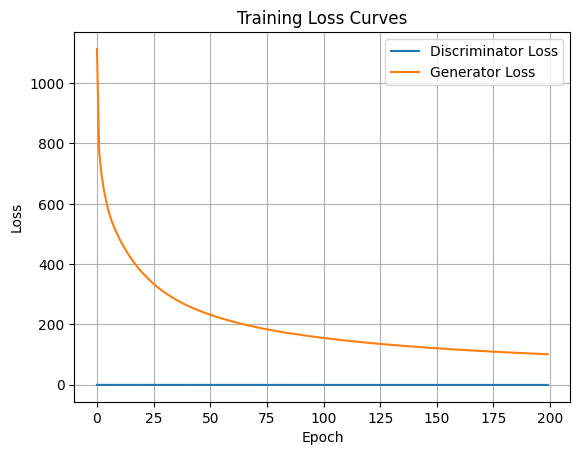

In [ ]:
plt.plot(d_loss_log, label='Discriminator Loss')
plt.plot(g_loss_log, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
os.makedirs("/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/blurred", exist_ok=True)
os.makedirs("/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/target", exist_ok=True)
os.makedirs("/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/deblurred", exist_ok=True)
os.makedirs("/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/deblurredFixed", exist_ok=True)

In [19]:
# evaluate PSNR performance for each saved generator model over epochs

# custom keras layer
@tf.keras.utils.register_keras_serializable()
class ReflectionPadding2D(tf.keras.layers.Layer):
    # mirror padding
    def __init__(self, padding=(1, 1), data_format='channels_last', **kwargs):
        super().__init__(**kwargs)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif isinstance(padding, tuple):
            self.padding = padding
        else:
            raise ValueError(f"Invalid padding: {padding}")
        self.data_format = data_format

    # apply reflection padding based on channel format
    def call(self, inputs):
        if self.data_format == 'channels_first':
            pattern = [[0, 0], [0, 0], list(self.padding[0]), list(self.padding[1])]
        else:
            pattern = [[0, 0], list(self.padding[0]), list(self.padding[1]), [0, 0]]
        return tf.pad(inputs, pattern, mode='REFLECT')

    # saving and reloading model with the custom layer
    def get_config(self):
        config = super().get_config()
        config.update({
            'padding': self.padding,
            'data_format': self.data_format
        })
        return config

# load the images
def load_and_preprocess_image(path):
    # resize to 256 x 256
    img = Image.open(path).convert('RGB').resize((256, 256))
    # normalization
    img = (np.array(img).astype('float32') - 127.5) / 127.5
    return img

def list_image_files(directory):
    return sorted([os.path.join(directory, f) for f in os.listdir(directory)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# dataset paths
test_sequence = "GOPR0372_07_00"
base_path = "/content/drive/My Drive/DSAN6500_Project/GOPRO_Large/train"
blur_dir = os.path.join(base_path, test_sequence, "blur")
sharp_dir = os.path.join(base_path, test_sequence, "sharp")
blur_paths = list_image_files(blur_dir)[:10]
sharp_paths = list_image_files(sharp_dir)[:10]

# preprocess the images
x_test = np.array([load_and_preprocess_image(p) for p in blur_paths])
y_test = np.array([load_and_preprocess_image(p) for p in sharp_paths])

# saved generator models
model_dir = "/content/drive/My Drive/DSAN6500_Project"
model_files = sorted([f for f in os.listdir(model_dir) if f.startswith("generator_") and f.endswith(".keras")])

# epochs passed from file names
epochs = []
# PSNR values
psnr_scores = []

# evaluate all the models
for file in model_files:
    try:
        # parse epoch number from filename
        epoch_str = file.split("_")[1]
        epoch_num = int(epoch_str)
        epochs.append(epoch_num)

        # load the generator model
        model = load_model(os.path.join(model_dir, file),
                           custom_objects={"ReflectionPadding2D": ReflectionPadding2D},
                           safe_mode=False)

        # predict deblurred images
        preds = model.predict(x_test, verbose=0)

        # convert to pixel scale [0, 255]
        preds_scaled = preds * 127.5 + 127.5
        y_scaled = y_test * 127.5 + 127.5

        # compute PSNR for each image
        psnr = tf.image.psnr(y_scaled, preds_scaled, max_val=255.0)
        # average PSNR over the batch
        psnr_scores.append(np.mean(psnr.numpy()))

    # for debugging
    except Exception as e:
        print(f"Error with model {file}: {e}")

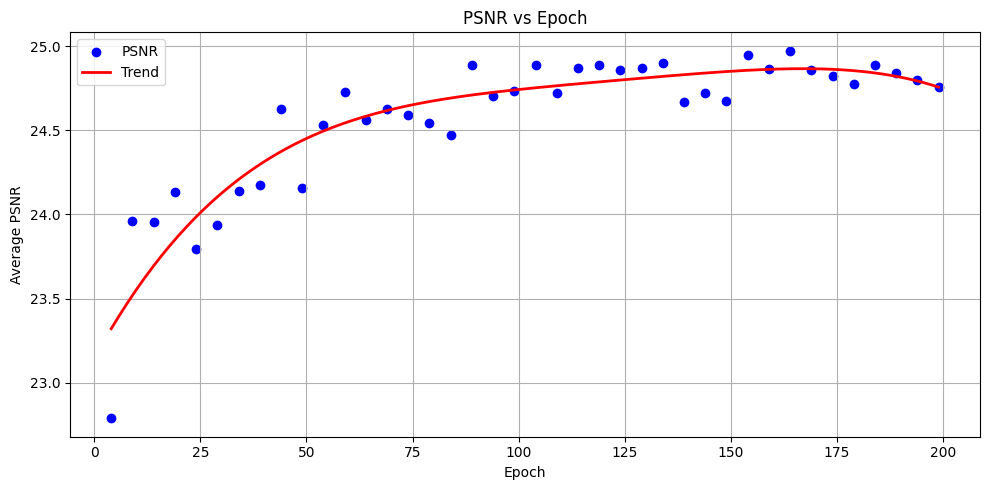

In [38]:
# PSNR scatter plot
if psnr_scores:
    plt.figure(figsize=(10, 5))

    # scatter plot
    plt.scatter(epochs[:len(psnr_scores)], psnr_scores, color='blue', label='PSNR')

    # 4th degree trend line
    z = np.polyfit(epochs[:len(psnr_scores)], psnr_scores, 4)
    p = np.poly1d(z)

    x_smooth = np.linspace(min(epochs), max(epochs), 300)
    y_smooth = p(x_smooth)


    plt.plot(x_smooth, y_smooth, color='red', linestyle='-', linewidth=2, label='Trend')

    plt.xlabel("Epoch")
    plt.ylabel("Average PSNR")
    plt.title("PSNR vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# for debugging
else:
    print("No PSNR values")


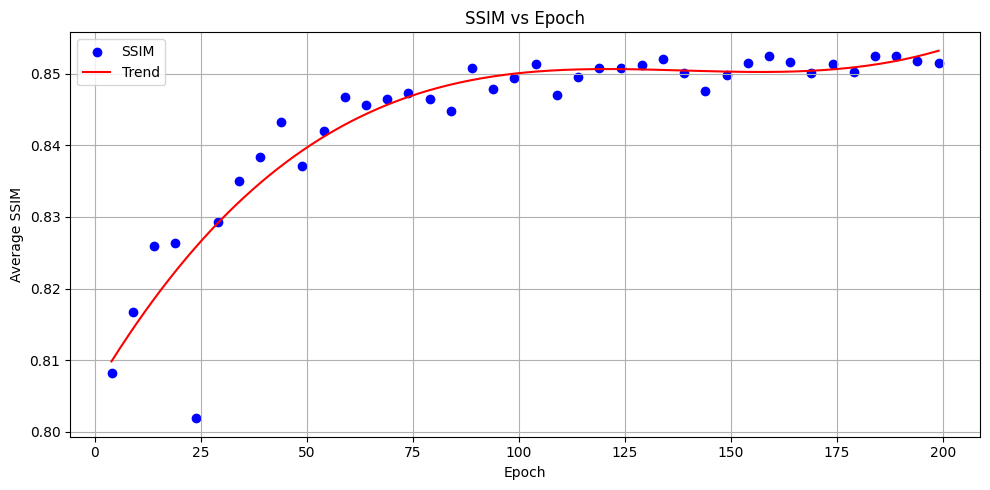

In [37]:
# SSIM scatter plot

if ssim_scores:
    plt.figure(figsize=(10, 5))

    plt.scatter(epochs[:len(ssim_scores)], ssim_scores, color='blue', label='SSIM')

    z = np.polyfit(epochs[:len(ssim_scores)], ssim_scores, deg=3)
    p = np.poly1d(z)

    x_smooth = np.linspace(min(epochs), max(epochs), 300)
    y_smooth = p(x_smooth)

    plt.plot(x_smooth, y_smooth, color='red', label='Trend')

    plt.xlabel("Epoch")
    plt.ylabel("Average SSIM")
    plt.title("SSIM vs Epoch")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No SSIM scores were successfully computed.")


# Testing

In [23]:
keras.config.enable_unsafe_deserialization()

def test_from_png(base_path, sequence, batch_size):
    blur_dir = os.path.join(base_path, sequence, "blur")
    sharp_dir = os.path.join(base_path, sequence, "sharp")

    blur_paths = list_image_files(blur_dir)[:batch_size]
    sharp_paths = list_image_files(sharp_dir)[:batch_size]

    x_test = np.array([load_and_preprocess_image(p) for p in blur_paths])
    y_test = np.array([load_and_preprocess_image(p) for p in sharp_paths])

    # load full model
    #custom_objects = {"ReflectionPadding2D": ReflectionPadding2D, "Lambda": keras.layers.Lambda}
    g = load_model('/content/drive/My Drive/DSAN6500_Project/generator_164_114.keras',
                   compile=False,
                   custom_objects={
                       'ReflectionPadding2D': ReflectionPadding2D
                   }
                   )

    # generate deblurred images
    generated_images = g.predict(x_test, batch_size=batch_size, verbose=0)

    # post process
    x_test = (x_test * 127.5 + 127.5).astype(np.uint8)
    y_test = (y_test * 127.5 + 127.5).astype(np.uint8)
    generated = (generated_images * 127.5 + 127.5).astype(np.uint8)


    # save the output
    for i in range(batch_size):
        x = x_test[i]
        y = y_test[i]
        img = generated[i]

        cv2.imwrite(f"/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/blurred/{i}.png", x)
        cv2.imwrite(f"/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/target/{i}.png", y)
        cv2.imwrite(f"/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/deblurred/{i}.png", img)

        # increase the brightness
        im = Image.fromarray(img)
        enhancer = ImageEnhance.Brightness(im)
        enhanced_im = enhancer.enhance(1.05)
        enhanced_im.save(f"/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/deblurredFixed/{i}.png")

        output = np.concatenate((y, x, img), axis=1)
        Image.fromarray(output).save(f"results_{i}.png")

    return generated


In [24]:
# run inference on blurry test images
generated_images = test_from_png(
    base_path="/content/drive/My Drive/DSAN6500_Project/GOPRO_Large/test",
    sequence="GOPR0862_11_00",
    batch_size=20
)


In [42]:
import tensorflow as tf
import numpy as np

def evaluate_generated_images(batch_size):
    base_path = "/content/drive/My Drive/DSAN6500_Project/ProcessedDeblurGAN_Dataset/"
    avg_psnr_pred, avg_psnr_blur = 0.0, 0.0
    avg_ssim_pred, avg_ssim_blur = 0.0, 0.0

    for i in range(batch_size):
        # Load images
        deblurred = np.array(Image.open(f"{base_path}/deblurred/{i}.png"))
        blurred = np.array(Image.open(f"{base_path}/blurred/{i}.png"))
        target = np.array(Image.open(f"{base_path}/target/{i}.png"))

        # Add batch dimension
        deblurred = deblurred[np.newaxis, ...]
        blurred = blurred[np.newaxis, ...]
        target = target[np.newaxis, ...]

        # PSNR
        psnr_pred = tf.image.psnr(tf.convert_to_tensor(target, dtype=tf.float32),
                                  tf.convert_to_tensor(deblurred, dtype=tf.float32),
                                  max_val=255.0).numpy()[0]
        psnr_blur = tf.image.psnr(tf.convert_to_tensor(target, dtype=tf.float32),
                                  tf.convert_to_tensor(blurred, dtype=tf.float32),
                                  max_val=255.0).numpy()[0]

        # SSIM
        ssim_pred = tf.image.ssim(tf.convert_to_tensor(target, dtype=tf.float32),
                                  tf.convert_to_tensor(deblurred, dtype=tf.float32),
                                  max_val=255.0).numpy()[0]
        ssim_blur = tf.image.ssim(tf.convert_to_tensor(target, dtype=tf.float32),
                                  tf.convert_to_tensor(blurred, dtype=tf.float32),
                                  max_val=255.0).numpy()[0]

        #print(f"Image {i}")
        #print(f"  PSNR - Deblurred vs Target: {psnr_pred:.2f}, Blurred vs Target: {psnr_blur:.2f}")
        #print(f"  SSIM - Deblurred vs Target: {ssim_pred:.4f}, Blurred vs Target: {ssim_blur:.4f}")
        #print()

        # Accumulate
        avg_psnr_pred += psnr_pred
        avg_psnr_blur += psnr_blur
        avg_ssim_pred += ssim_pred
        avg_ssim_blur += ssim_blur

    # Averages
    print("=== Averages ===")
    print(f"Average PSNR - Deblurred vs Target: {avg_psnr_pred / batch_size:.2f}")
    print(f"Average PSNR - Blurred vs Target: {avg_psnr_blur / batch_size:.2f}")
    print(f"Average SSIM - Deblurred vs Target: {avg_ssim_pred / batch_size:.4f}")
    print(f"Average SSIM - Blurred vs Target: {avg_ssim_blur / batch_size:.4f}")
